In [63]:
import sys

if "data" in sys.modules:
    sys.modules.pop("data")
from lib.data import train_data, targets, features, LOGS_PATH, make_train_valid_datasets
if "plot" in sys.modules:
    sys.modules.pop("plot")
from lib.plot import plot_predictions

import tensorflow as tf
import keras
import numpy as np
from keras.layers import LSTM, GRU, Dense
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, CalendarSeasonality, CalendarTimeTrend
from calendar import day_name
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(context="notebook", style="whitegrid", rc={"figure.dpi": 100})

%config InlineBackend.figure_format = 'retina'

In [64]:
df = train_data(delta=True)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/davidenicoli/mambaforge/envs/MLA/lib/python3.10/site-packages/keras/backend.py", line 5132, in <genexpr>
    output_ta_t = tuple(  File "/Users/davidenicoli/mambaforge/envs/MLA/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


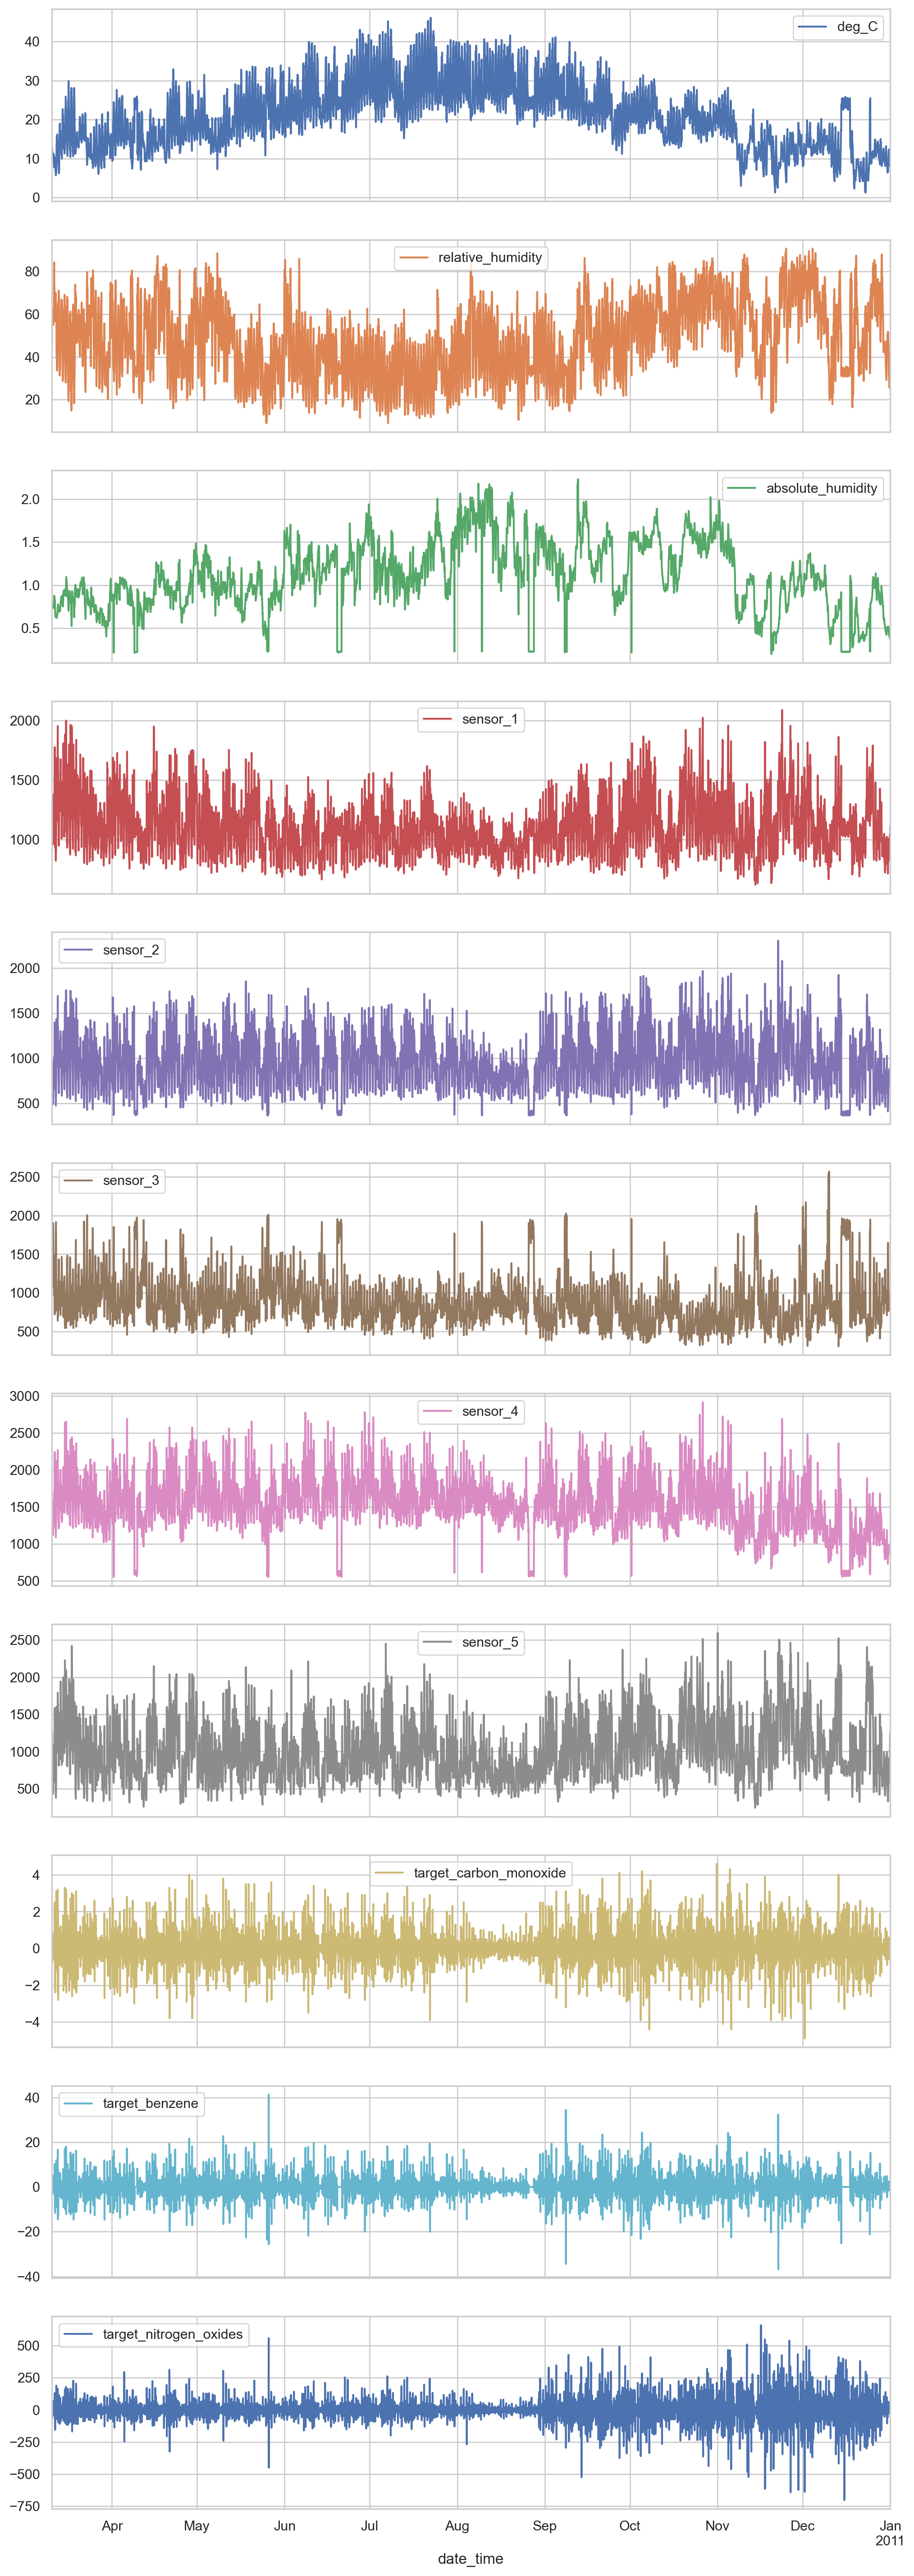

In [65]:
df[features + targets].plot(subplots=True, figsize=(12, 36));

There are 3 periods that should be omitted

## Temporal features analysis
Immagino che il giorno della settimana e l'ora del giorno siano features con una grossa influenza sulle concentrazioni.
Indago:

In [66]:
day_type = pd.CategoricalDtype(list(day_name), ordered=True)
df["weekday"] = df.index.day_name().astype(day_type)
df["week"] = df.index.isocalendar().week.astype("int")
df["hour"] = df.index.hour
df["day"] = df.index.day_of_year
df["season"] = df.index.quarter.map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [67]:
def seasonal_plot(X, y, freq, sep, ax=None, **kwargs):
    return sns.lineplot(
        data=X,
        x=freq,
        y=y,
        hue=sep,
        estimator="median",
        errorbar=("pi", 90),
        ax=ax,
        **kwargs
    )

<Axes: xlabel='hour', ylabel='target_carbon_monoxide'>

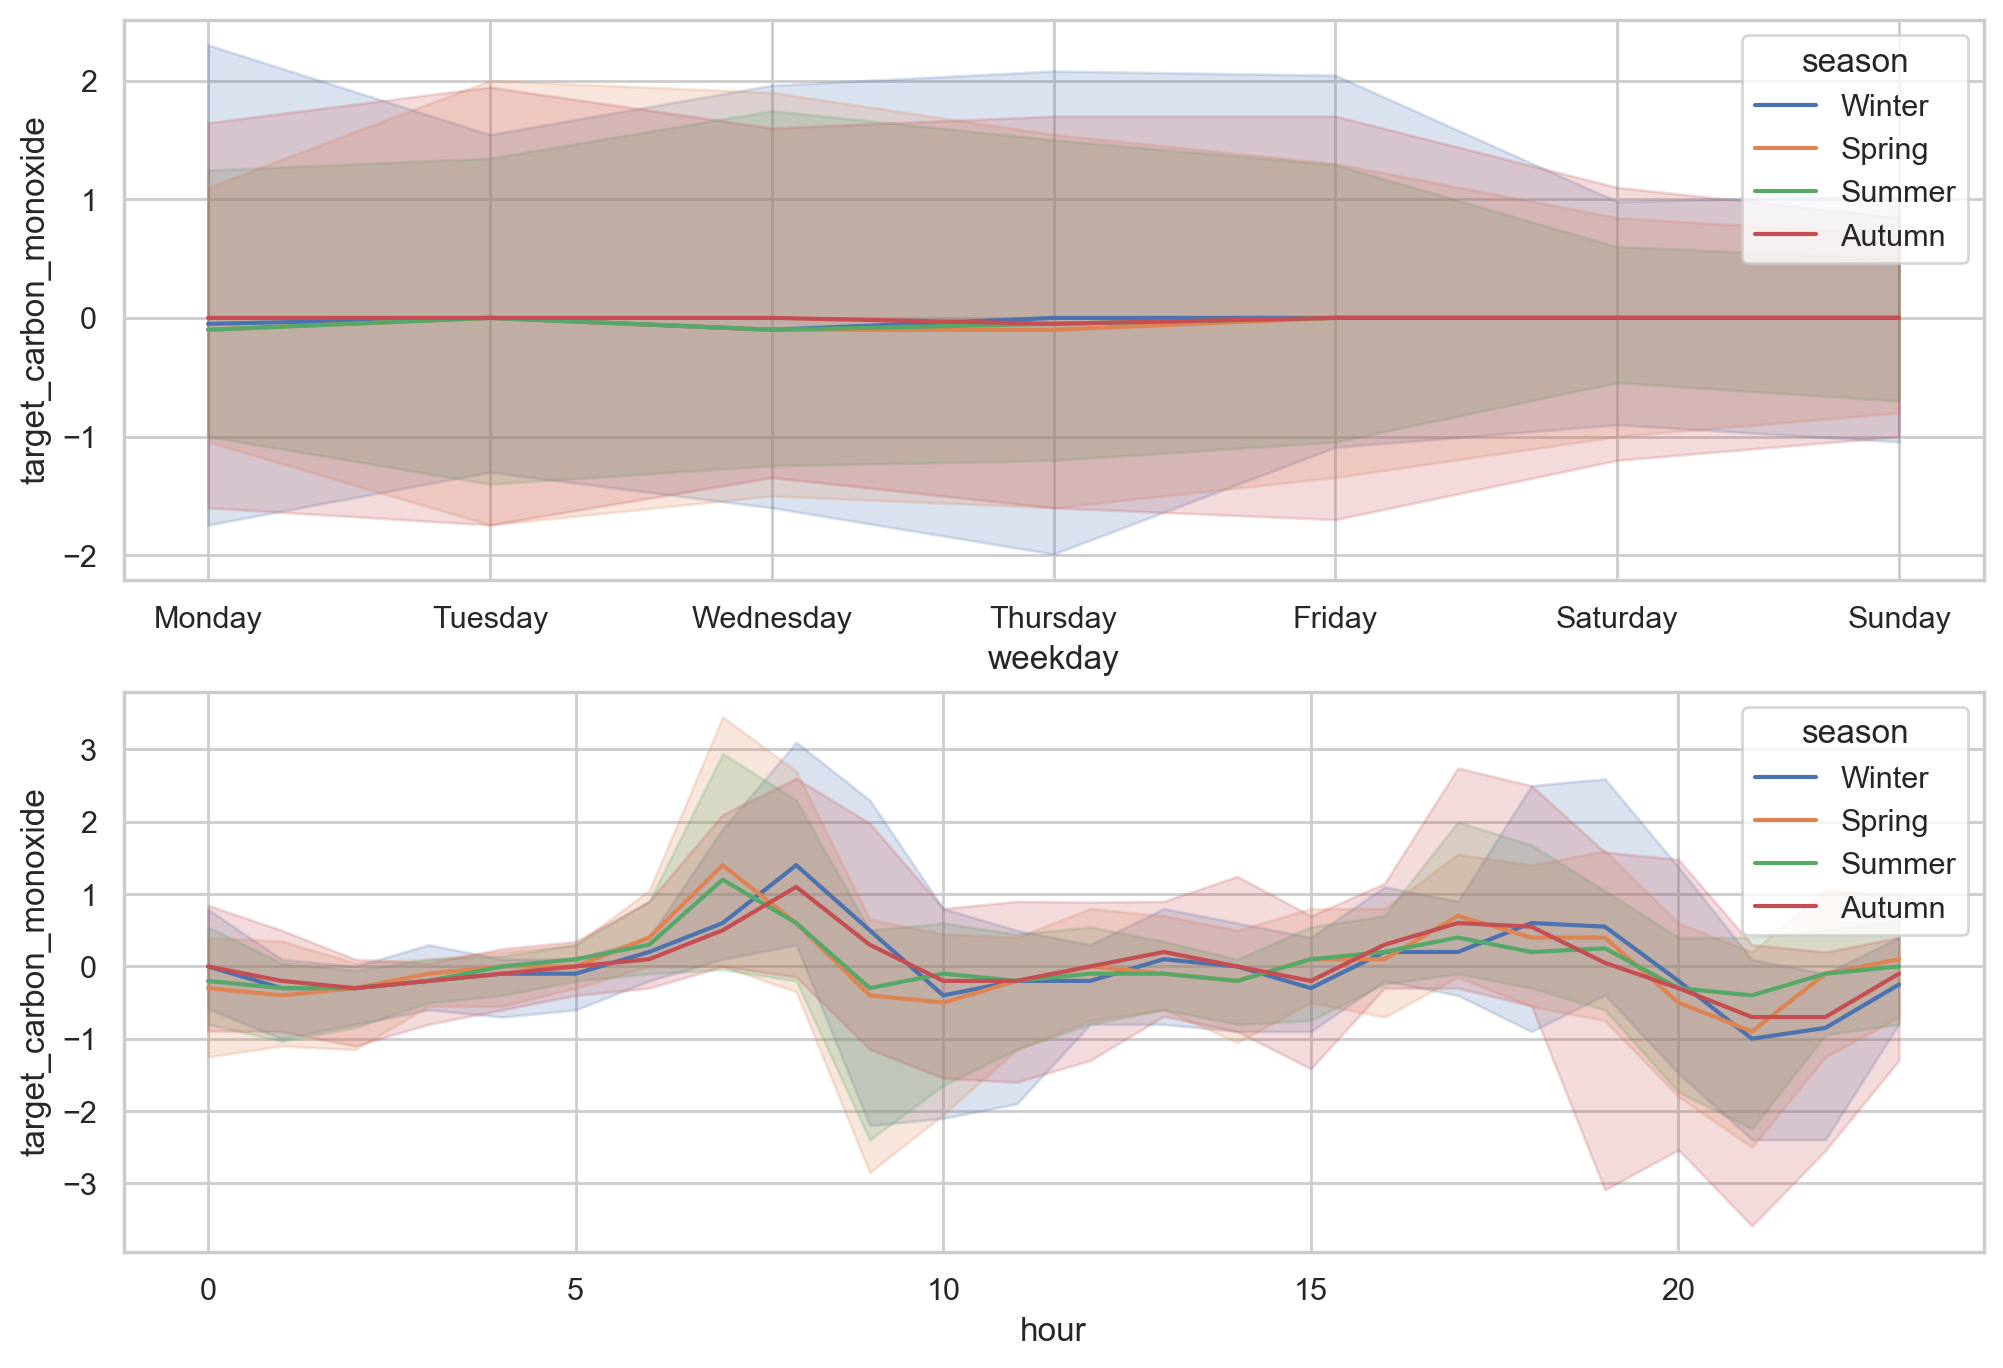

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df.to_period("H"), y=targets[0], freq="weekday", sep="season", ax=axes[0])
seasonal_plot(df.to_period("H"), y=targets[0], freq="hour", sep="season", ax=axes[1])

<Axes: xlabel='hour', ylabel='target_benzene'>

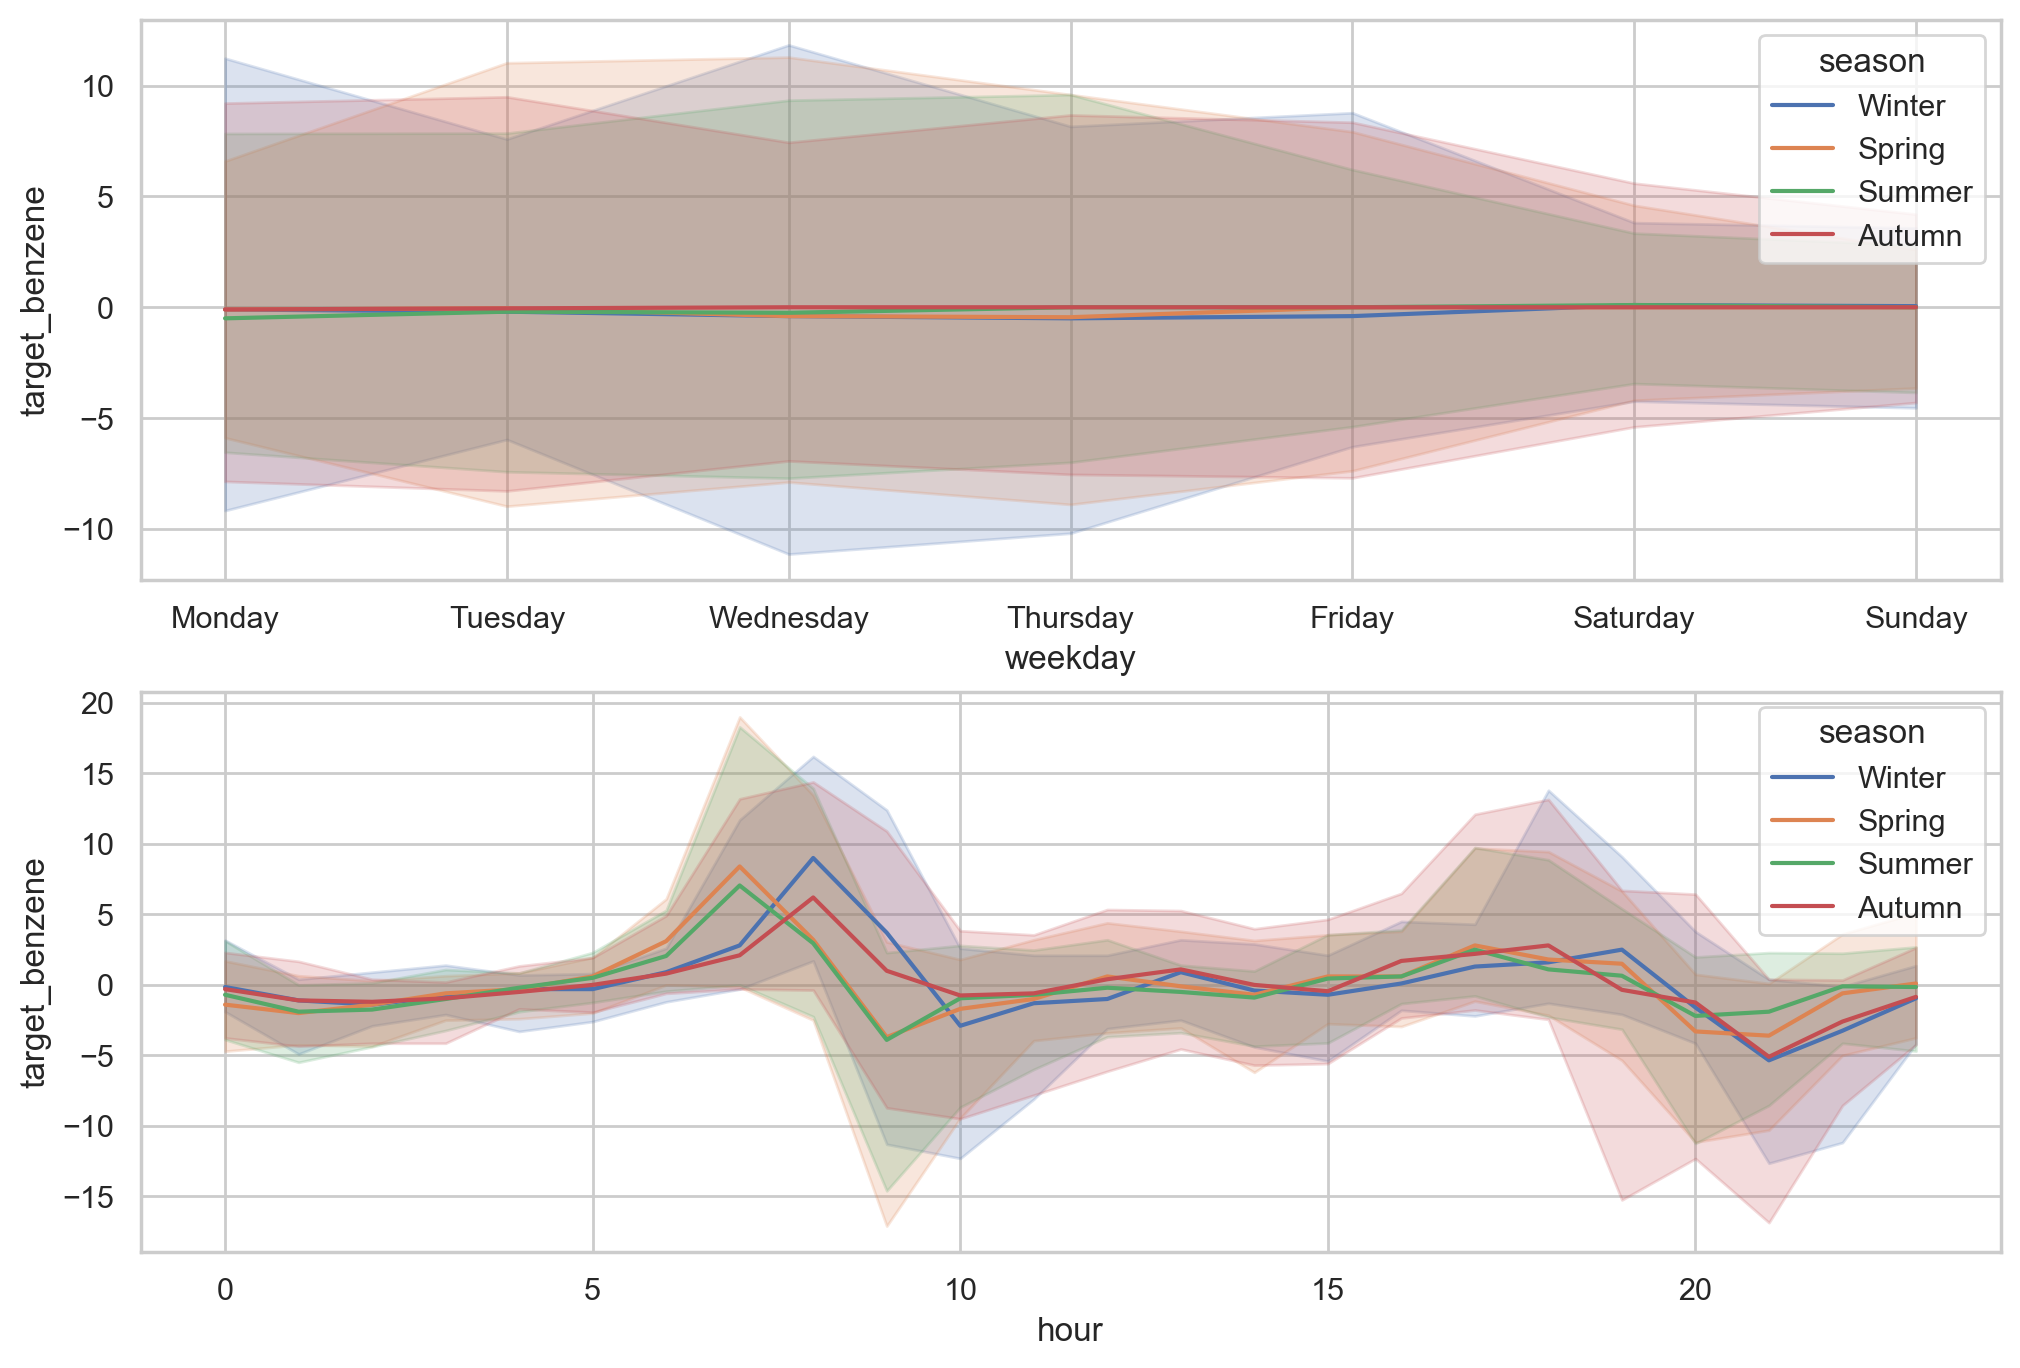

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df.to_period("H"), y=targets[1], freq="weekday", sep="season", ax=axes[0])
seasonal_plot(df.to_period("H"), y=targets[1], freq="hour", sep="season", ax=axes[1])

<Axes: xlabel='hour', ylabel='target_nitrogen_oxides'>

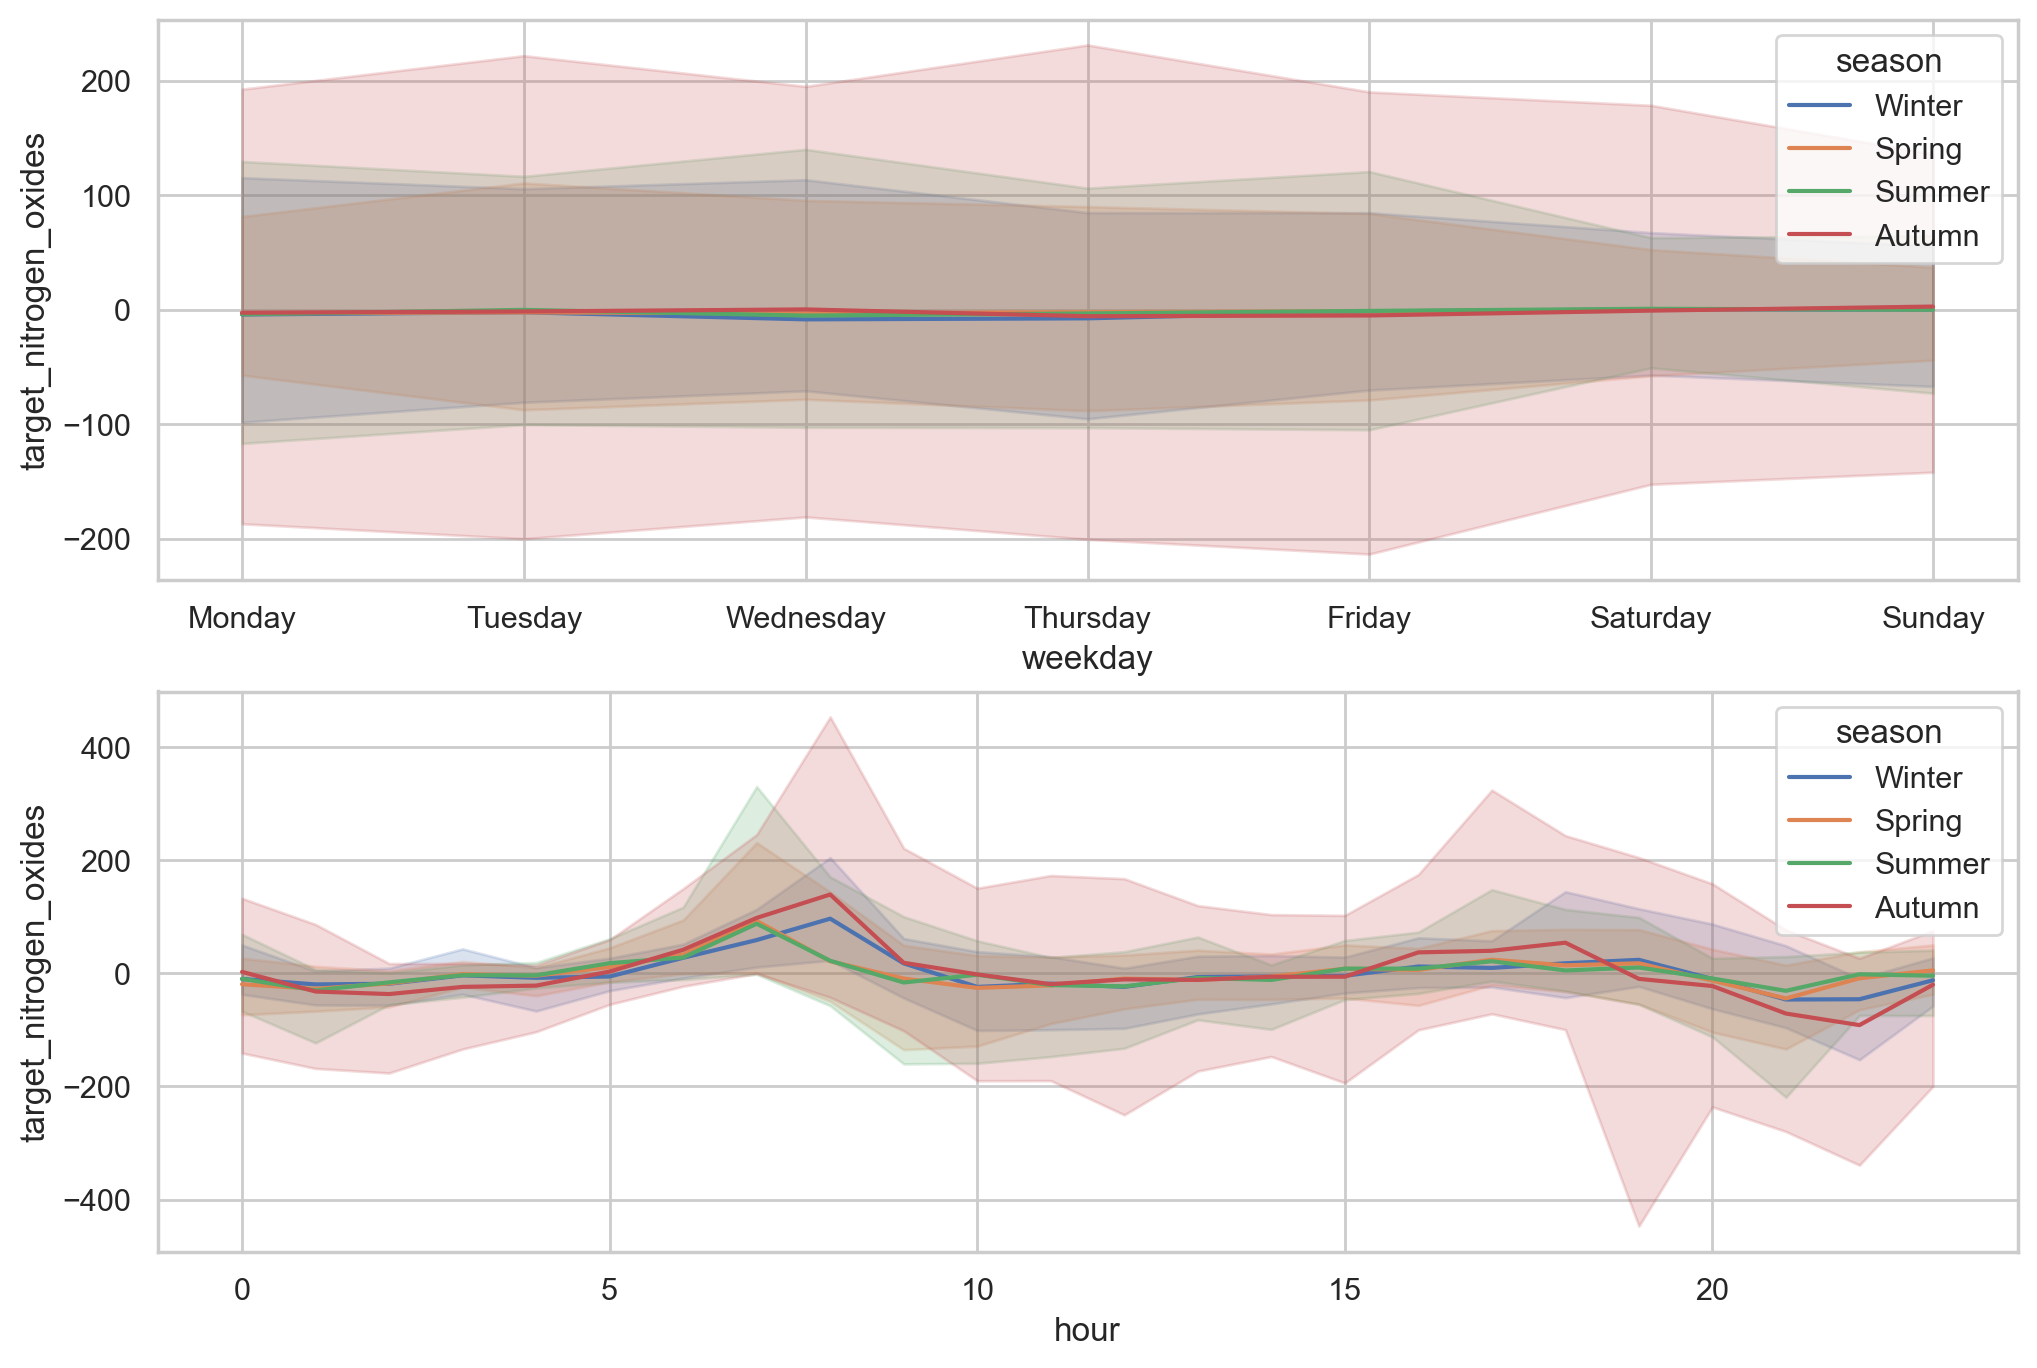

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df.to_period("H"), y=targets[2], freq="weekday", sep="season", ax=axes[0])
seasonal_plot(df.to_period("H"), y=targets[2], freq="hour", sep="season", ax=axes[1])

Weak dependence on the weekday, strong dependence on the hour. Similar trends across all targets. Different behaviours depending on seasons.

Time features to extract:
- hour of day;
- weekday (feature);
- season (feature);

In [71]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1H")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 12, 26, 52, 104, 365, 730, 365*4])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "Daily (365)",
            "Twice a day (730)",
            f"Four times a day ({365*4})"
        ],
        rotation=30,
        ha="right"
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    if ts.name:
        ax.set_title(ts.name)
    return ax

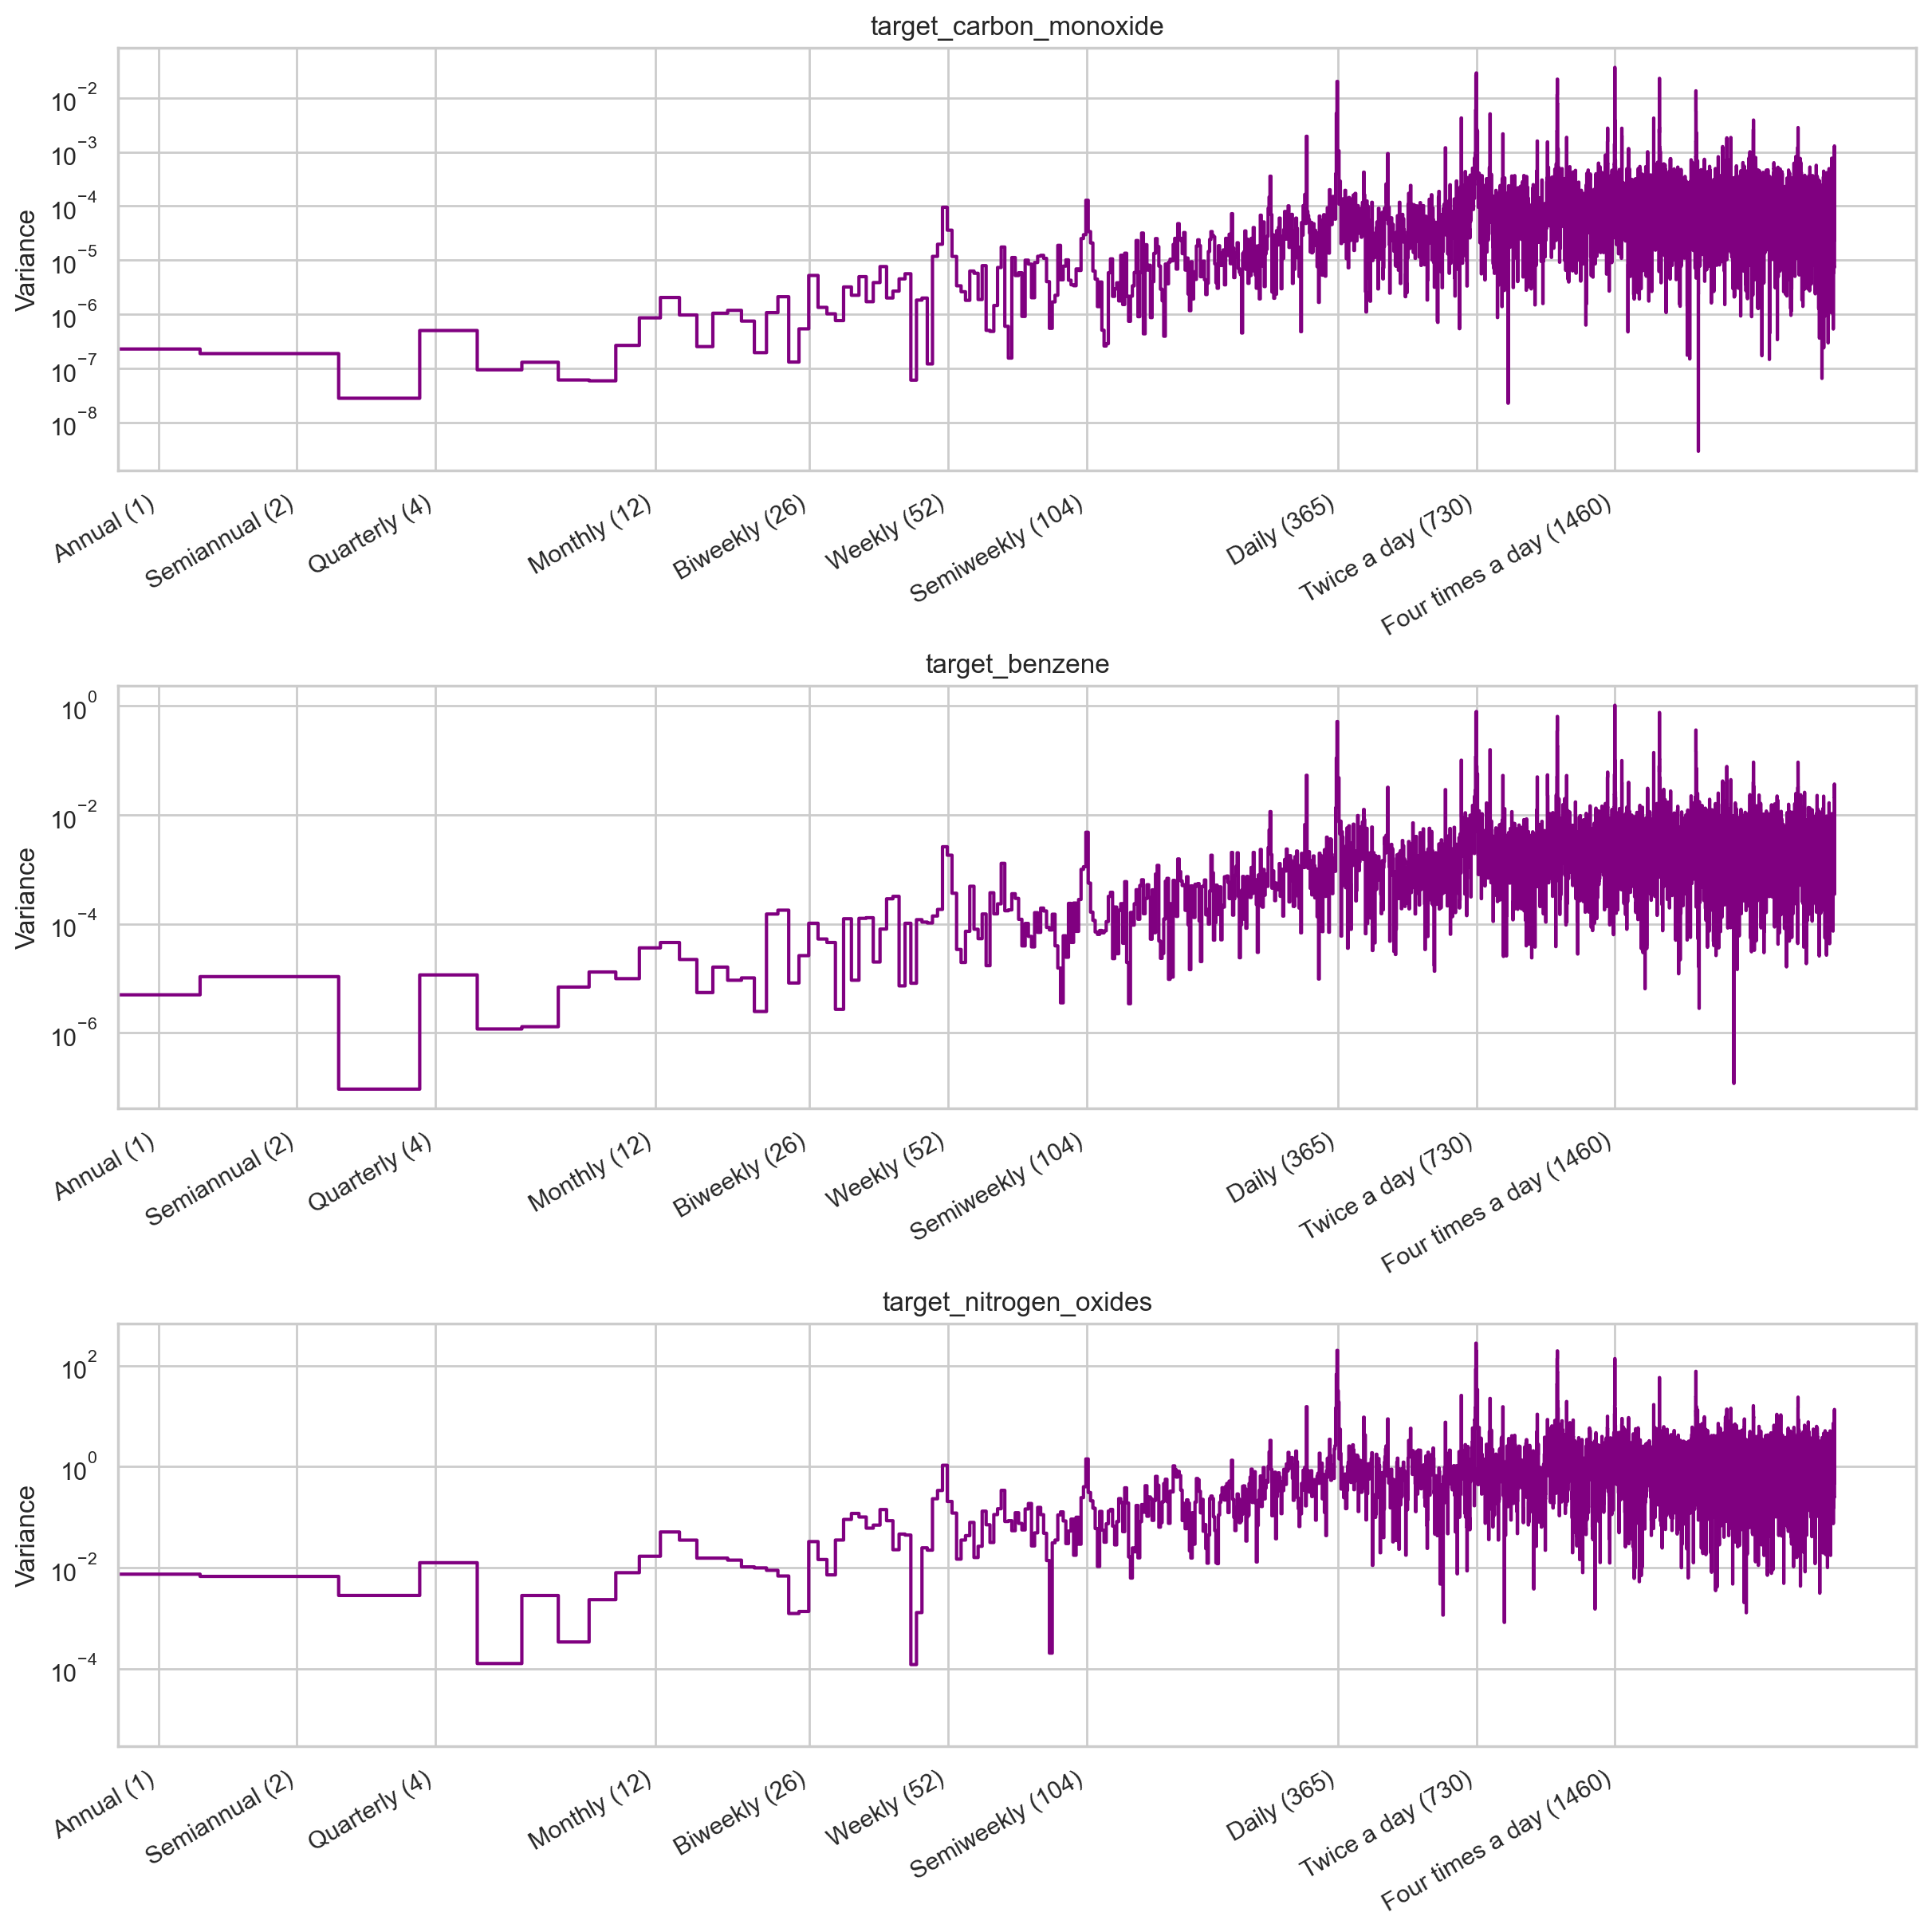

In [72]:
_, axes = plt.subplots(3, figsize=(12, 12), constrained_layout=True)
for ax, target in zip(axes, targets):
    plot_periodogram(df[target], detrend=None, ax=ax)
    ax.set_yscale("log")

In [73]:
in_day_features = CalendarFourier("D", 8)
# in_year_features = CalendarSeasonality("M", "A")
# in_week_features = CalendarSeasonality("D", "W")
time_features = DeterministicProcess(
    df.to_period().index,
    constant=True,
    additional_terms=[in_day_features],
    drop=True
)
X_periodic = time_features.in_sample()
y = df[targets]

In [74]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_periodic, y)

In [75]:
y_pred = model.predict(X_periodic)

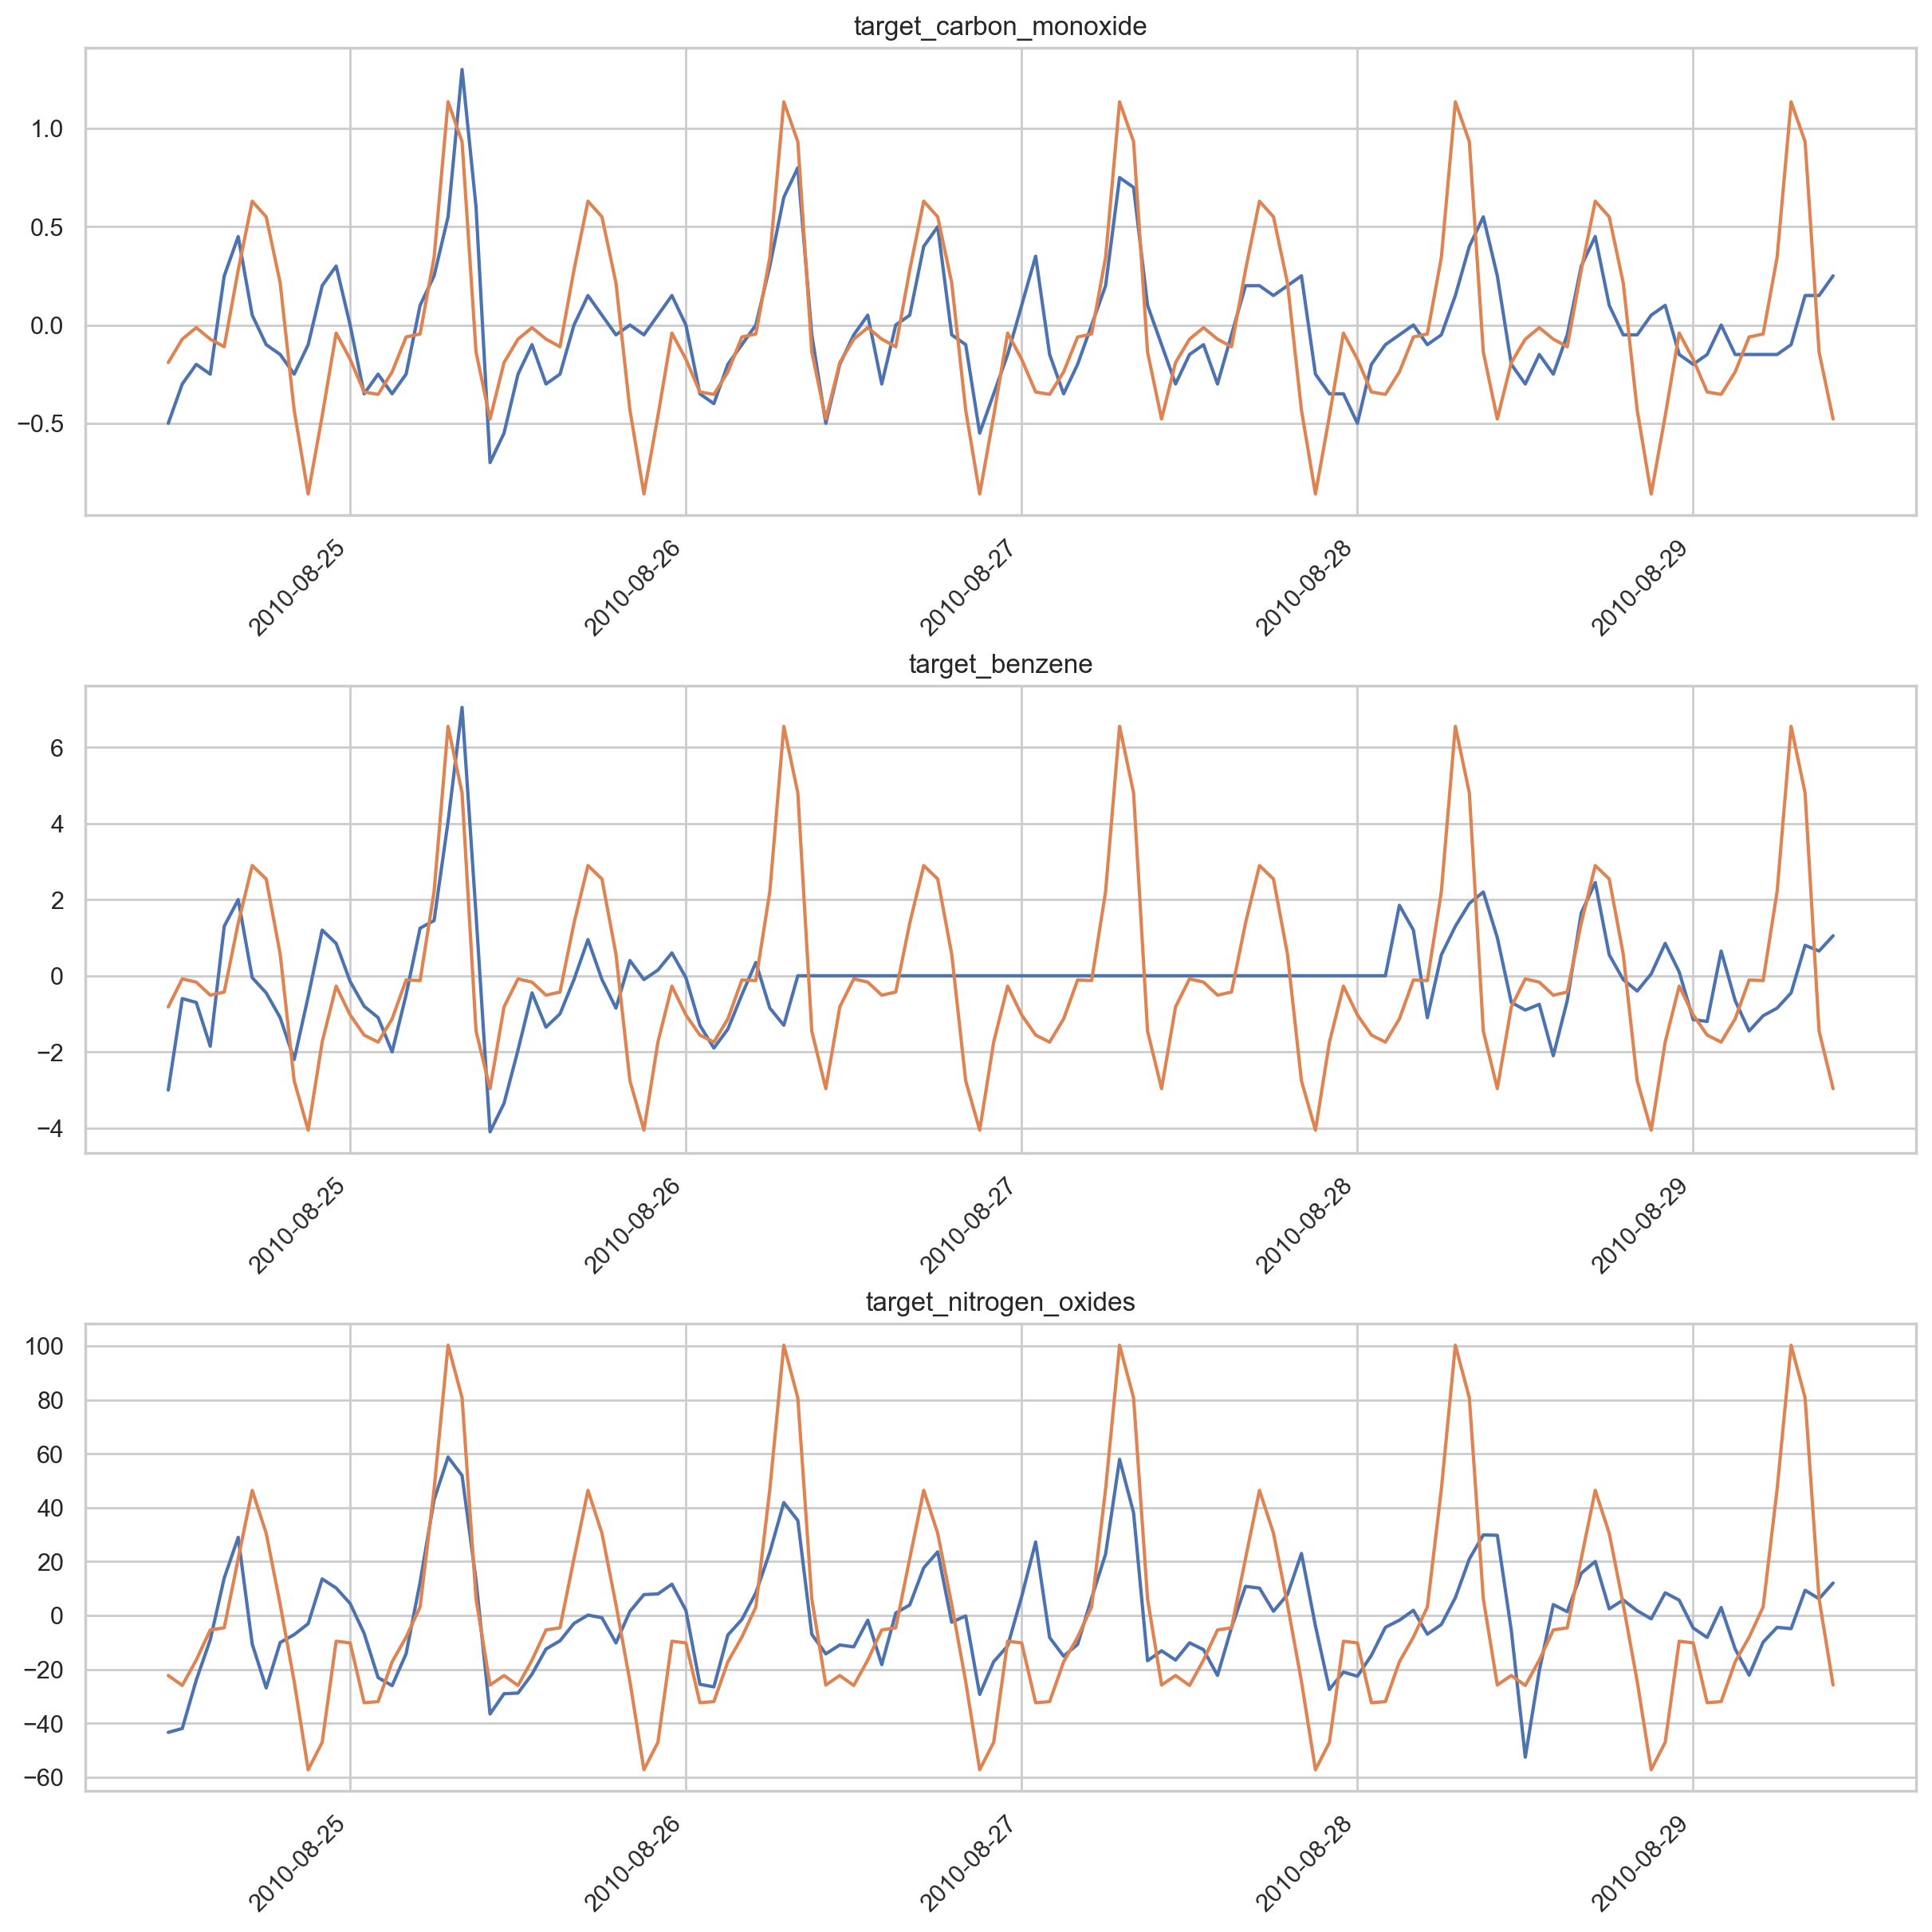

In [76]:
def plot_baseline(X, y_target, y_predicted, days, target, ax: plt.Axes):
    ax.plot(X.index, y_target.rolling(int(days*24), min_periods=int(days*12), center=True).mean().to_numpy()[:, target])
    ax.plot(X.index, y_predicted[:, target])
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

fig, axes = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
for ax, (i,target) in zip(axes, enumerate(targets)):
    plot_baseline(X_periodic.iloc[4000:4000+24*5].to_timestamp(), y.iloc[4000:4000+24*5], y_pred[4000:4000+24*5], 1/12, i, ax)
    ax.set_title(target)

In [77]:
y_detrend = y - y_pred

(0.0001, 100.0)

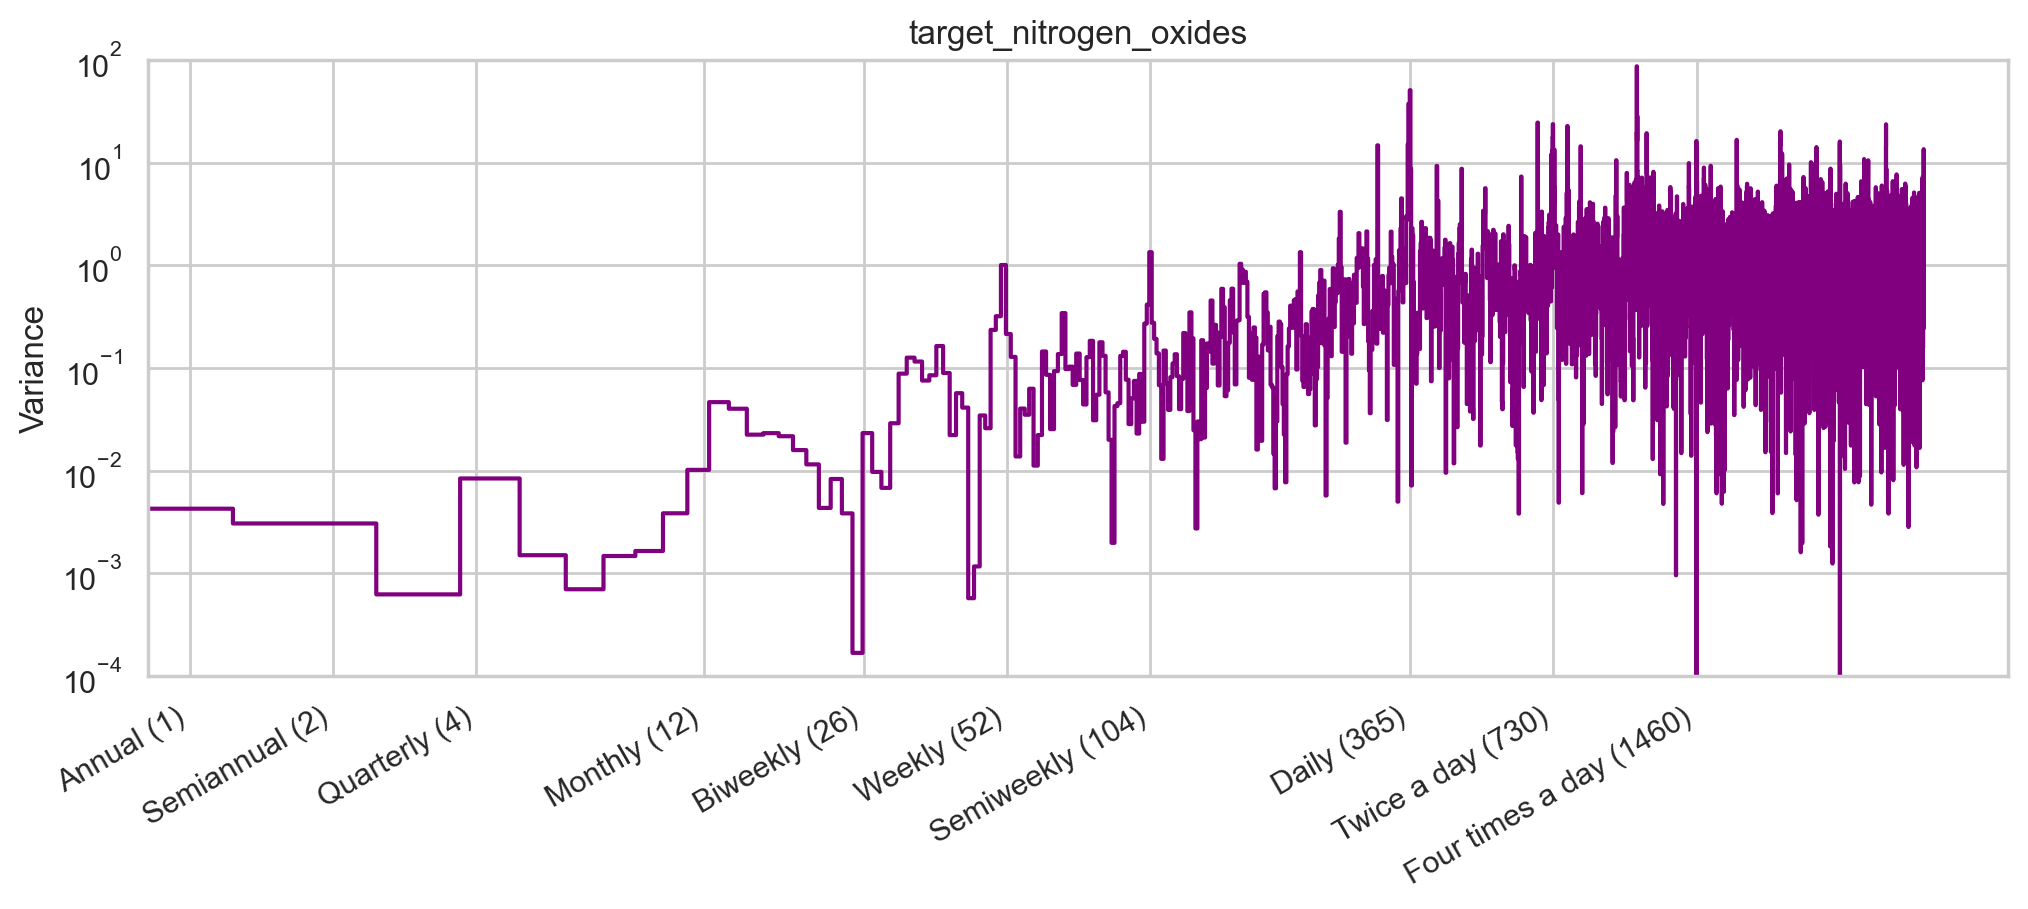

In [78]:
_, ax = plt.subplots(figsize=(12, 4))
plot_periodogram(y_detrend[targets[2]], detrend=None, ax=ax)
ax.set_yscale("log")
ax.set_ylim(1e-4, 1e2)

In [79]:
# Building the windowed dataset
import tensorflow as  tf
input_days = 7
output_days = 1/24
with tf.device("/CPU:0"):
    train_ds, valid_ds = make_train_valid_datasets(input_days, output_days, 0.2, delta=True)
    norm_layer = keras.layers.Normalization()
    norm_layer.adapt(train_ds.batch(10).map(lambda x, _: x))

In [28]:
with tf.device("/CPU:0"):
    model = keras.Sequential([
        norm_layer,
        LSTM(4, return_sequences=True),
        Dense(len(targets))
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(train_ds.shuffle(1000).batch(10),
        validation_data=valid_ds.batch(10),
        epochs=2, callbacks=[keras.callbacks.TensorBoard(LOGS_PATH)])
    

Epoch 1/2
23/23 [==============================] - 3s 126ms/step - loss: 1359.8160 - val_loss: 18047.9082
Epoch 2/2
23/23 [==============================] - 3s 122ms/step - loss: 1358.2123 - val_loss: 18055.0000


In [104]:
a = df[targets].iloc[:300]
b = df[targets].iloc[300:600]
c = pd.concat([a.reset_index(drop=True), b.reset_index(drop=True)], keys=["a", "b"], axis=1)

In [105]:
a = tf.data.Dataset.from_tensor_slices(a)
b = tf.data.Dataset.from_tensor_slices(b.iloc[:40])
tf.data.Dataset.zip((a, b))

<ZipDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>